In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy

In [2]:
#%matplotlib widget
%matplotlib inline

In [3]:
#from platform import python_version
#python_version()

In [4]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [5]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'NGC_2243'

## Getting RA&DEC from Bica 2019

In [6]:
df = pd.read_csv('../../lista.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]

## Querying the data

In [7]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [8]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [9]:
query = """SELECT 
source_id, ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b, 
ruwe, phot_g_n_obs, phot_bp_n_obs, phot_rp_n_obs
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' + ' 0.4))'

In [10]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
data = job.get_results()
len(data)

11118

In [12]:
#data

## Converting to pandas

In [13]:
df = data.to_pandas()
df

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs
0,2893901753766044544,97.792373,-31.429192,1.523380,0.379851,-0.348092,0.341571,0.917454,19.797855,-0.069191,0.357922,NaN,NaN,239.751979,-17.748748,1.016068,366,42,44
1,2893923335975836928,97.370044,-31.412057,-0.891738,0.201124,5.533659,0.203037,0.995785,19.092386,0.395697,0.190654,NaN,NaN,239.597304,-18.078173,1.038402,418,44,45
2,2893932647466908416,97.225188,-31.496476,0.053457,0.483719,-1.346470,0.553438,0.512619,20.366043,0.244867,0.537731,NaN,NaN,239.633046,-18.223922,1.008450,343,36,38
3,2893932647466999680,97.225946,-31.494819,NaN,NaN,NaN,NaN,1.869101,20.912540,NaN,NaN,NaN,NaN,239.631666,-18.222721,NaN,75,8,12
4,2893186865048460032,96.970240,-31.441330,3.752956,0.425570,-1.085185,0.529043,1.274546,18.366491,-0.271797,0.444639,NaN,NaN,239.496281,-18.406866,3.724276,435,52,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11113,2894728792668113280,97.336187,-30.904303,-0.042883,0.140320,2.384405,0.148918,0.880444,18.787292,0.008163,0.141777,NaN,NaN,239.088926,-17.920428,0.973674,462,52,48
11114,2894728792668120320,97.334999,-30.892344,-0.684110,0.082240,1.286724,0.084944,0.792898,17.725649,0.092837,0.080943,NaN,NaN,239.076834,-17.917012,1.048334,427,48,48
11115,2894728796965995136,97.342159,-30.892113,5.030405,0.025612,1.402884,0.027129,1.041278,15.489806,1.052306,0.025630,NaN,NaN,239.078965,-17.911207,1.087089,460,49,49
11116,2894728831322914048,97.357289,-30.888330,-0.646550,0.274224,3.697592,0.275174,0.901665,19.661901,-0.306048,0.274237,NaN,NaN,239.080245,-17.897739,1.002504,415,46,42


In [197]:
#import plotly.express as px

In [198]:
#fig = px.scatter(x = df.pmra_error, y = df.pmra)
#fig.show()

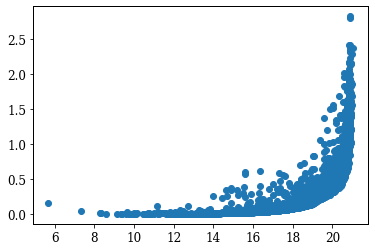

In [199]:
fig, ax = plt.subplots()

ax.scatter(df.phot_g_mean_mag, df.pmra_error)

## Applying better conditions to the variables

In [14]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(5686, 11118)

## Dropping uknown values of pmra, pmdec or parallax.

In [15]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'parallax', 'parallax_error'])
ndf

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs
1,2893923335975836928,97.370044,-31.412057,-0.891738,0.201124,5.533659,0.203037,0.995785,19.092386,0.395697,0.190654,NaN,NaN,239.597304,-18.078173,1.038402,418,44,45
8,2893186899408224512,96.975775,-31.421868,22.202150,0.153886,-7.373902,0.190595,2.673719,18.914728,2.301438,0.163106,NaN,NaN,239.478936,-18.395456,1.058989,444,50,52
14,2893186972426377728,96.969764,-31.415506,-1.191418,0.383216,11.144553,0.512784,1.879881,20.196770,0.913434,0.400965,NaN,NaN,239.470735,-18.397951,0.978702,402,31,38
16,2893187247300711680,96.950659,-31.397152,31.259534,0.304639,6.700431,0.367241,2.160019,19.933136,0.711200,0.330435,NaN,NaN,239.446503,-18.406558,1.028405,443,45,47
18,2893187277365342336,96.985043,-31.424467,2.132831,0.111838,1.462243,0.140199,1.211956,18.406353,0.408535,0.121525,NaN,NaN,239.484491,-18.389012,0.972523,439,54,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11109,2894728655229160960,97.293252,-30.901669,-2.529417,0.105511,0.751033,0.116010,0.959270,18.320297,0.377197,0.106128,NaN,NaN,239.072222,-17.953768,1.007152,462,54,52
11110,2894728655229163776,97.297792,-30.896186,-0.554278,0.103133,8.893626,0.111544,0.938283,16.570286,0.360384,0.101566,NaN,NaN,239.068350,-17.948141,2.457734,434,50,49
11111,2894728659524307584,97.288936,-30.900700,3.497518,0.577382,-1.245975,0.592779,1.780281,20.518538,2.023469,0.591355,NaN,NaN,239.069854,-17.956863,1.040458,367,27,40
11112,2894728659527263232,97.296847,-30.899691,-1.989171,0.010293,3.955373,0.011938,0.632215,13.365909,0.644209,0.011110,34.593307,4.674046,239.071469,-17.950174,1.056092,436,51,51


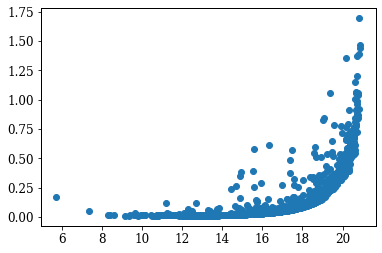

In [202]:
fig, ax = plt.subplots()

ax.scatter(ndf.phot_g_mean_mag, ndf.pmra_error)

In [16]:
#.Definicão da função de correção de area
#.(calcula a parte da area de um círculo que esta fora das bordas da imagem)
def area_cor( radata, dedata, ap ):

    cosd = np.cos(dedata*np.pi/180.0)
    rarg = [min(radata),max(radata)]
    derg = [min(dedata),max(dedata)]
    
    b = np.array([(rarg[1]-radata)*cosd, (radata-rarg[0])*cosd, ap])
    c = np.array([ derg[1]-dedata, dedata-derg[0], ap ])
    b = np.min(b,axis=0)  ;  c = np.min(c,axis=0)
    P = 0.5*np.pi*ap**2 - c*np.sqrt(ap**2-c**2) - np.arcsin(c/ap)*ap**2
    Q = 0.5*np.pi*ap**2 - b*np.sqrt(ap**2-b**2) - np.arcsin(b/ap)*ap**2
    O = 0.5*( -c*np.sqrt(ap**2-c**2) - b*np.sqrt(ap**2-b**2) + \
     np.arccos(c/ap)*ap**2 - np.arcsin(b/ap)*ap**2) + c*b
    O = O*(abs(b) < np.sqrt(ap**2-c**2))
    area_cor = -P -Q +O
    return area_cor

0.0007420137942151854


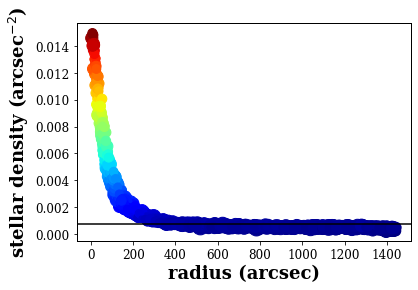

In [35]:
from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors


catalog = SkyCoord(ra=ndf['ra']*units.degree, dec=ndf['dec']*units.degree, frame='fk5')

nstar = len(ndf)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([ndf['ra'], ndf['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2 + area_cor(ndf.ra, ndf.dec, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(ndf['ra'], weights=den_data)
std_x = np.average((ndf['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(ndf['dec'], weights=den_data)
std_y = np.average((ndf['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')


norm_den = den_data/np.max(den_data)
bg_select = (norm_den > 0.04) & (norm_den < 0.15)
med_bg = np.median(den_data[bg_select])
std_bg = 0.5*med_bg


ax.axhline(med_bg, color = 'k')
print(med_bg)



In [36]:
raio_max = np.max(radii)*units.arcsec
raio_max = raio_max.to(units.radian).value
dens = med_bg
dens = dens*(1/units.arcsec*(1/units.arcsec))
dens = dens.to(1/units.sr).value
estrelas = len(df_condicionado) - dens*np.pi*raio_max**2
estrelas

827.2102947531603

## Creating the arrays to perform the 5-D HDBSCAN fit

In [37]:
cincoD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax']))[0]

## Performing the HDBSCAN

In [38]:
import hdbscan

In [39]:
from sklearn.preprocessing import RobustScaler

scaled = RobustScaler().fit_transform(cincoD)

Estimated no. of clusters: 1
Estimated no. of noise points: 3824
Estimated no. points clustered: 827


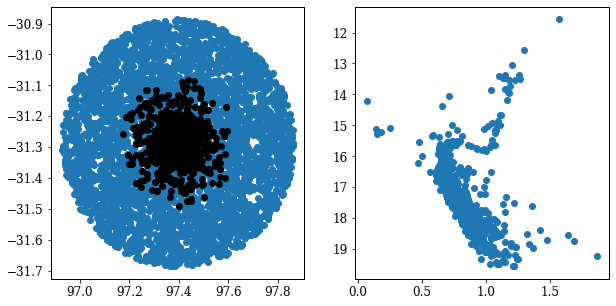

In [40]:
pts_expected = int(estrelas)

clusterer = hdbscan.HDBSCAN(min_cluster_size = pts_expected, min_samples = 400, allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(scaled)


labels = clusterer.labels_


ndf = ndf.assign(labels=labels)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]


fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)

ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


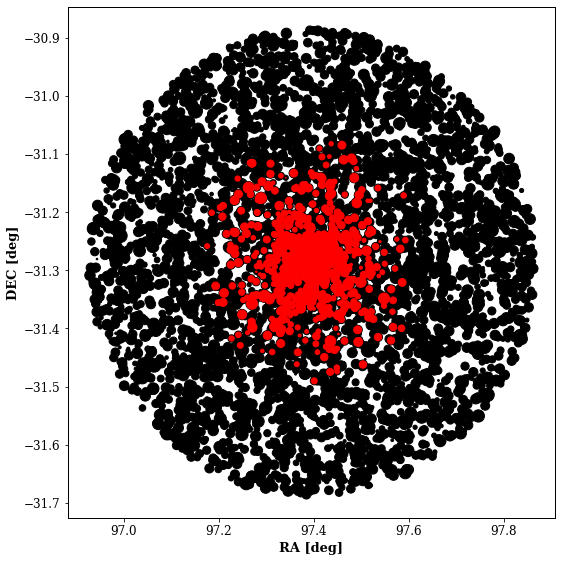

In [81]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(subset.ra,subset.dec,  s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, color = 'red', zorder = 100)
ax.scatter(ndf.ra,ndf.dec,  s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, color = 'k')
ax.set_xlabel('RA [deg]', fontweight = 'bold')
ax.set_ylabel('DEC [deg]', fontweight = 'bold')
plt.tight_layout()
plt.savefig('random_img.png', format = 'png', dpi = 300)


## Parameters

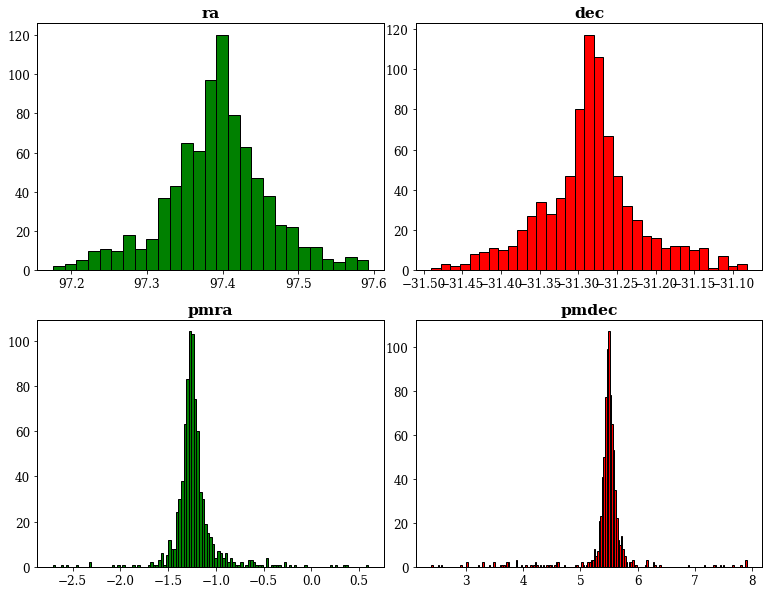

In [41]:
fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax1.hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax2.hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax3.hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax4.hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


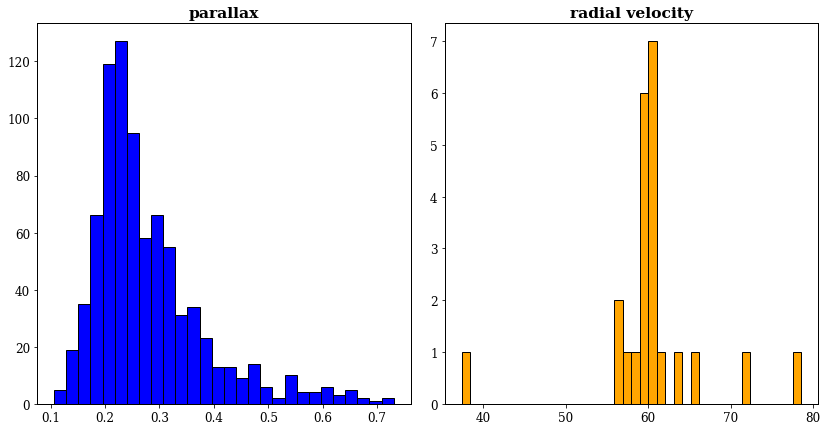

In [42]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax1.hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## Gaussian fit

In [43]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 28
    # variables        = 3
    chi-square         = 4312.68410
    reduced chi-square = 172.507364
    Akaike info crit   = 147.039115
    Bayesian info crit = 151.035728
[[Variables]]
    amplitude:  16.9026019 +/- 1.17243163 (6.94%) (init = 21.85261)
    center:     0.23156548 +/- 0.00501025 (2.16%) (init = 0.2264232)
    sigma:      0.06304829 +/- 0.00512775 (8.13%) (init = 0.05781113)
    fwhm:       0.14846736 +/- 0.01207493 (8.13%) == '2.3548200*sigma'
    height:     106.952359 +/- 7.36598931 (6.89%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.592


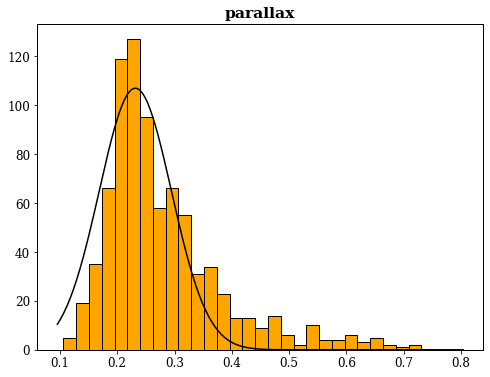

In [44]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0], histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 27
    # variables        = 3
    chi-square         = 2156.47628
    reduced chi-square = 89.8531782
    Akaike info crit   = 124.270637
    Bayesian info crit = 128.158147
[[Variables]]
    amplitude:  12.0332385 +/- 0.63001682 (5.24%) (init = 14.19381)
    center:     97.3953851 +/- 0.00313159 (0.00%) (init = 97.39678)
    sigma:      0.05180060 +/- 0.00313165 (6.05%) (init = 0.04009551)
    fwhm:       0.12198110 +/- 0.00737448 (6.05%) == '2.3548200*sigma'
    height:     92.6739734 +/- 4.85206829 (5.24%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


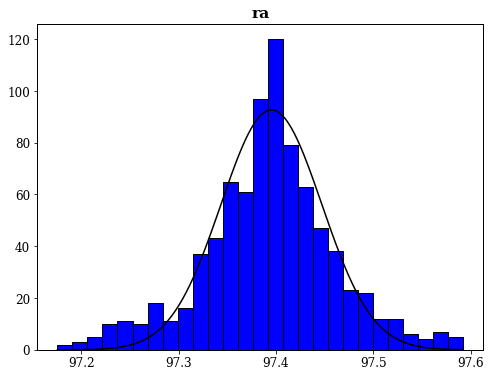

In [45]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 123
    # variables        = 3
    chi-square         = 1273.20770
    reduced chi-square = 10.6100642
    Akaike info crit   = 293.464578
    Bayesian info crit = 301.901131
[[Variables]]
    amplitude:  18.5658348 +/- 0.34363714 (1.85%) (init = 21.10528)
    center:    -1.26224294 +/- 0.00165330 (0.13%) (init = -1.259396)
    sigma:      0.07735820 +/- 0.00165333 (2.14%) (init = 0.06764513)
    fwhm:       0.18216463 +/- 0.00389330 (2.14%) == '2.3548200*sigma'
    height:     95.7454695 +/- 1.77216133 (1.85%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


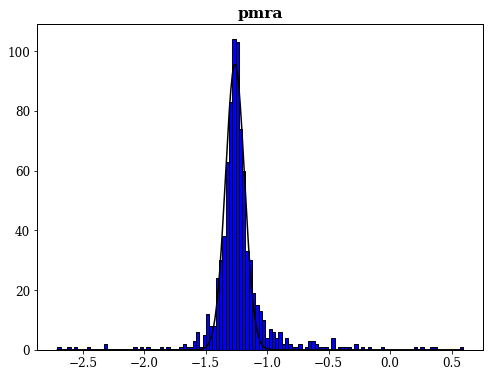

In [46]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 33
    # variables        = 3
    chi-square         = 3905.08863
    reduced chi-square = 130.169621
    Akaike info crit   = 163.526430
    Bayesian info crit = 168.015953
[[Variables]]
    amplitude:  8.49051472 +/- 0.56486108 (6.65%) (init = 6.656612)
    center:    -31.2826838 +/- 0.00277707 (0.01%) (init = -31.27976)
    sigma:      0.03615135 +/- 0.00277716 (7.68%) (init = 0.01912819)
    fwhm:       0.08512992 +/- 0.00653971 (7.68%) == '2.3548200*sigma'
    height:     93.6956853 +/- 6.23342555 (6.65%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


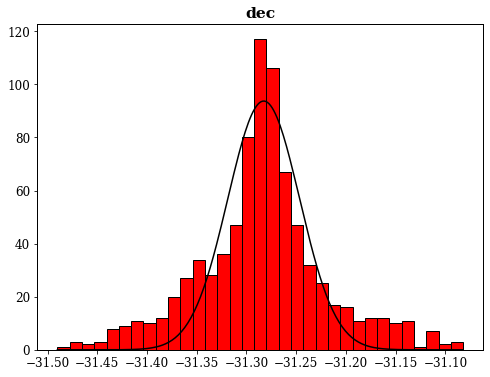

In [47]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 198
    # variables        = 3
    chi-square         = 968.817646
    reduced chi-square = 4.96829562
    Akaike info crit   = 320.386256
    Bayesian info crit = 330.251058
[[Variables]]
    amplitude:  19.5912423 +/- 0.24667270 (1.26%) (init = 17.91724)
    center:     5.49408250 +/- 0.00119987 (0.02%) (init = 5.499502)
    sigma:      0.08252957 +/- 0.00119988 (1.45%) (init = 0.05581694)
    fwhm:       0.19434228 +/- 0.00282550 (1.45%) == '2.3548200*sigma'
    height:     94.7027285 +/- 1.19239832 (1.26%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


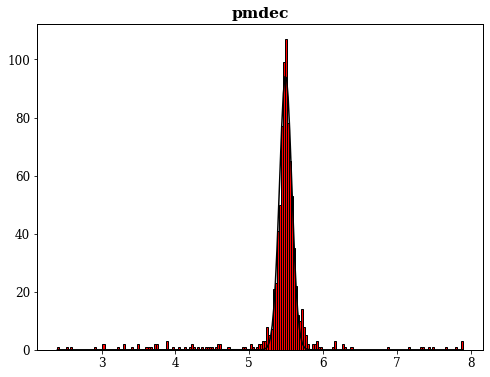

In [48]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 40
    # variables        = 3
    chi-square         = 10.0539592
    reduced chi-square = 0.27172863
    Akaike info crit   = -49.2365179
    Bayesian info crit = -44.1698796
[[Variables]]
    amplitude:  15.8917137 +/- 1.12891620 (7.10%) (init = 144.326)
    center:     60.1566391 +/- 0.05798087 (0.10%) (init = 60.61503)
    sigma:      0.76709680 +/- 0.07536826 (9.83%) (init = 6.872665)
    fwhm:       1.80637489 +/- 0.17747868 (9.83%) == '2.3548200*sigma'
    height:     8.26476763 +/- 0.64490739 (7.80%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.617
    C(center, sigma)    = 0.103


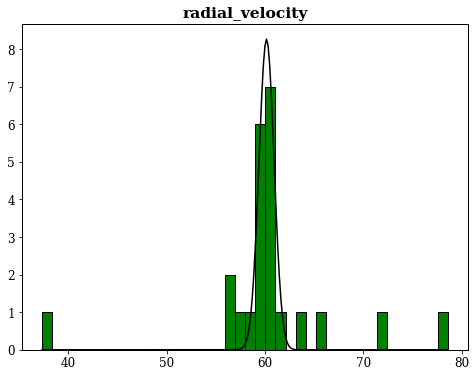

In [49]:
fig, ax = plt.subplots(figsize=(8,6))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'green');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]


xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radial_velocity', fontweight = 'bold')

plt.show()

## Sigma Clipping

827
383
282


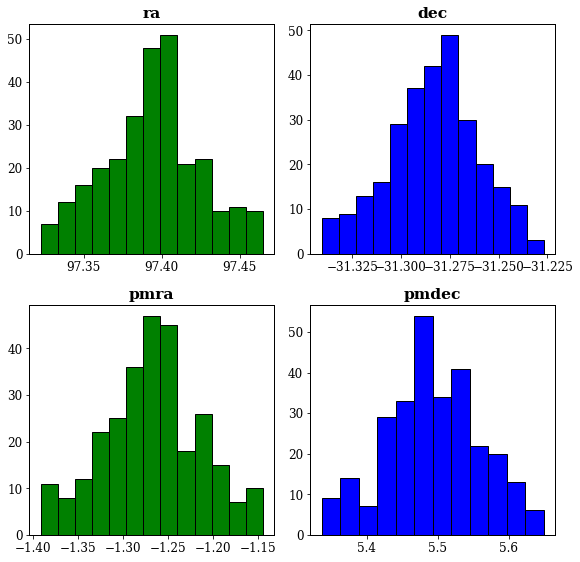

In [85]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 2

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)  & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax1.hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax2.hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax3.hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'blue');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax4.hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'blue');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.tight_layout()
plt.savefig('teste_params.png', format = 'png', dpi = 300)


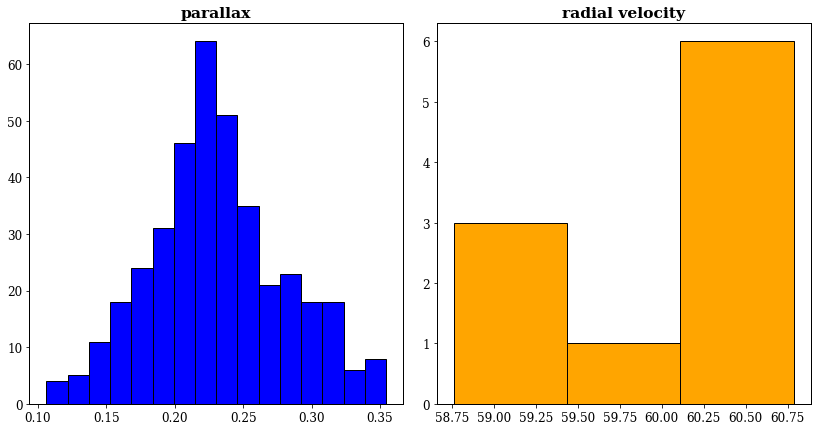

In [62]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(clip_loop['parallax'], bins = 'fd')
ax1.hist(clip_loop['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## FINAL RESULTS

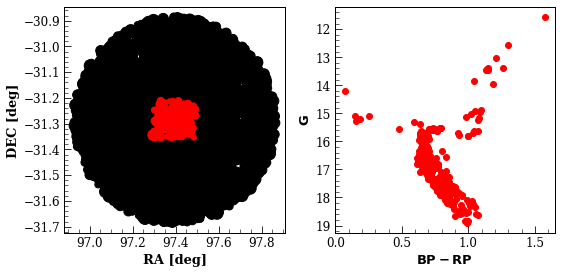

In [73]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
from matplotlib.ticker import AutoMinorLocator

ax[0].scatter(clip_loop.ra,clip_loop.dec, color = 'red',s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec, color = 'k', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20)


ax[1].scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'], color = 'red')
ax[1].invert_yaxis()



ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[1].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[1].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[1].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[0].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[0].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[0].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[0].set_xlabel('RA [deg]', fontweight = 'bold')
ax[0].set_ylabel('DEC [deg]', fontweight = 'bold')
ax[1].set_ylabel(r'$\mathbf{G}$')
ax[1].set_xlabel(r'$\mathbf{BP - RP}$')
plt.tight_layout()
plt.savefig('final_campo_aglomerado.png', format = 'png', dpi = 300)


In [64]:
from astropy.coordinates import Distance

teste =  Distance(parallax=clip_loop['parallax'].to_numpy()*units.mas)

np.min(teste), np.max(teste)

(<Distance 2820.69692861 pc>, <Distance 9418.32297576 pc>)

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

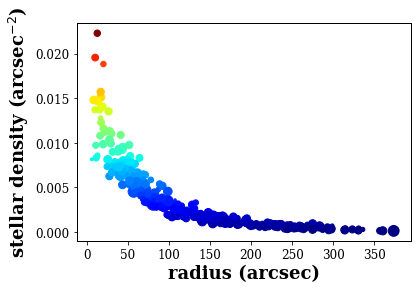

In [65]:
from astropy.coordinates import SkyCoord, Angle
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [66]:
clip_loop.to_csv('final_5d.csv', index=False)

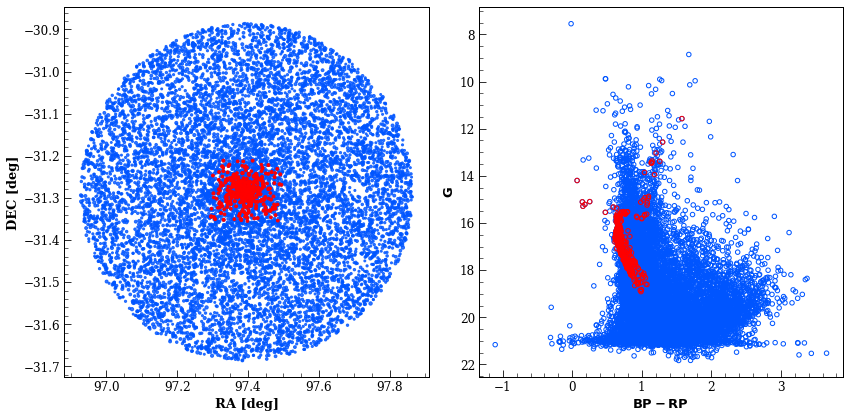

In [71]:
from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,(1,3))
ax2 = fig.add_subplot(2,2,(2,4))


ax1.scatter(df['ra'],df['dec'], color = '#0055FF',s=(25-df.phot_g_mean_mag), alpha = 0.8)
ax1.scatter(clip_loop['ra'],clip_loop['dec'], color = 'red', s=(25-clip_loop.phot_g_mean_mag), zorder = 10)
ax1.set_ylabel('DEC [deg]', fontweight = 'bold')
ax1.set_xlabel('RA [deg]', fontweight = 'bold')

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax1.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax1.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax1.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)




ax2.scatter(df['bp_rp'],df['phot_g_mean_mag'], color = 'None', edgecolor = '#0055FF', s = 20)
ax2.scatter(clip_loop['bp_rp'], clip_loop['phot_g_mean_mag'], color = 'None', edgecolor = 'red', s =20)
ax2.set_xlabel('BP - RP', fontweight = 'bold')
ax2.set_ylabel('G', fontweight = 'bold')
ax2.invert_yaxis()
ax2.set_ylabel(r'$\mathbf{G}$')
ax2.set_xlabel(r'$\mathbf{BP - RP}$')
#ax2.grid()

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax2.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax2.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax2.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

plt.tight_layout()
#plt.savefig('teste.jpg', format = 'jpg', dpi = 300)

In [68]:
cantat_table = pd.read_csv('table_cantat.csv')
cantat_table.head()

,_RAJ2000,_DEJ2000,_r,RA_ICRS,DE_ICRS,GaiaDR2,Plx,pmRA*,pmDE,RV,o_Gmag,Gmag,BP-RP,proba,Cluster,Teff50,Simbad,_RA.icrs,_DE.icrs
0,97.433206,-31.374202,0.097783,97.433200,-31.374178,2893929314573452800,0.213638,-1.256852,5.446781,NaN,316,16.688720,0.680159,1.0,http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-i...,6489.2960,Simbad,97.433206,-31.374202
1,97.421653,-31.378807,0.099423,97.421646,-31.378782,2893929314573457664,0.203491,-1.223026,5.690101,NaN,317,17.859926,0.798615,1.0,http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-i...,NaN,Simbad,97.421653,-31.378807
2,97.417407,-31.358609,0.078940,97.417401,-31.358585,2893929378994269440,0.188119,-1.236098,5.510903,NaN,303,16.711750,0.676086,1.0,http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-i...,6577.2676,Simbad,97.417407,-31.358609
3,97.412663,-31.361045,0.080448,97.412657,-31.361021,2893929383292930432,0.297147,-1.141086,5.496320,NaN,312,17.404829,0.759626,1.0,http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-i...,6104.3740,Simbad,97.412663,-31.361045
4,97.418984,-31.368753,0.089115,97.418977,-31.368730,2893929383292932608,0.235116,-1.291414,5.410456,NaN,323,16.303950,0.669328,1.0,http://vizier.u-strasbg.fr/viz-bin/VizieR-4?-i...,6427.7896,Simbad,97.418984,-31.368753


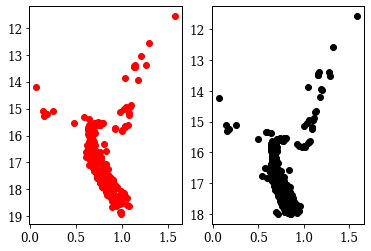

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,(1,3))
ax2 = fig.add_subplot(2,2,(2,4))

ax1.scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'], color = 'red')
ax2.scatter(cantat_table['BP-RP'],cantat_table['Gmag'], color = 'k')
ax1.invert_yaxis()
ax2.invert_yaxis()

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

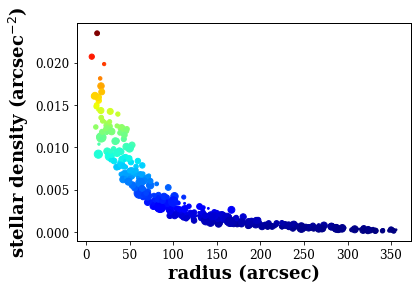

In [70]:
from astropy.coordinates import SkyCoord, Angle
from astropy import units

catalog = SkyCoord(ra=cantat_table['_RAJ2000']*units.degree, dec=cantat_table['_DEJ2000']*units.degree, frame='fk5')

nstar = len(cantat_table)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([cantat_table['_RAJ2000']*np.cos(cantat_table['_DEJ2000']*np.pi/180.0), cantat_table['_DEJ2000']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(cantat_table['_RAJ2000'], weights=den_data)
std_x = np.average((cantat_table['_RAJ2000']-med_x)**2, weights=den_data)**0.5

med_y = np.average(cantat_table['_DEJ2000'], weights=den_data)
std_y = np.average((cantat_table['_DEJ2000']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(cantat_table['Gmag'])-cantat_table['Gmag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [74]:
one = pd.read_csv('1not2.csv')
two = pd.read_csv('2not1.csv')
match = pd.read_csv('match.csv')

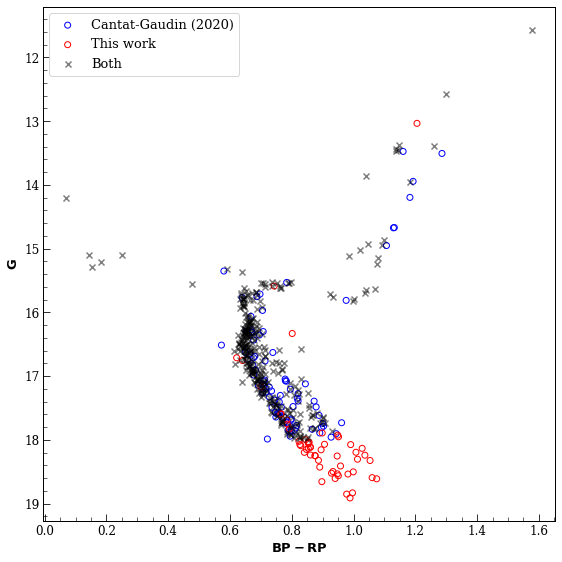

In [80]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(one['BP-RP'],one.Gmag, color = 'none', edgecolor = 'b', label = 'Cantat-Gaudin (2020)')
ax.scatter(two.bp_rp, two.phot_g_mean_mag, color = 'none', edgecolor = 'red', label = 'This work')
ax.scatter(match.bp_rp,match.phot_g_mean_mag,  marker ='x', color = 'k', alpha = 0.5, label = 'Both')
ax.invert_yaxis()
ax.legend()

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)
ax.set_ylabel(r'$\mathbf{G}$')
ax.set_xlabel(r'$\mathbf{BP - RP}$')
plt.tight_layout()
plt.savefig('crossmatch.png', format = 'png', dpi = 300)